# Simulation of multiple degrees-of-freedom (MDOF) systems

References:
- Khalid Jawed, "Notes on Discrete Simulation of Slender Structures", chapters 3 and 4.

Recall the equations of motion (with initial conditions) for a MDOF system, written as a system of first order ODEs:

Equations of motion for a MDOF system subject to conservative forces
$$ \begin{cases}
    \dot{v}_i = - \frac{1}{m_i} \frac{\partial E_p}{\partial q_i} \\
    v_i = \dot{q}_i \\
    q_i(0) = q_{i0} \\
    v_i(0) = v_{i0}
\end{cases}
$$
where $q_i$ are the degrees of freedom ($i = 1,..,N$), $v_i$ are the associated velocities, $m_i$ are the lumped masses, and $E_p$ is the potential energy.

In [48]:
import jax.numpy as jnp
from jax import jacfwd, jit, grad
from functools import partial
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Equations of motion (system of first order ODEs to integrate)
# @partial(jit, static_argnames=("P",))
# @jit
def equations_of_motion(t, z, P, m, c=0., F=0.):
    q, v = jnp.array_split(z, 2) # split state into positions and velocity
    dq_dt = v
    dv_dt = -grad(P)(q)/m-c*v/m+F/m
    return jnp.concatenate([dq_dt, dv_dt])

In [2]:
# Potential energy
def P(q):
    return 0.5*(q[1]-q[0] - 1.)**2

In [21]:
# Jacobian of the rhs of the system of equations of motion
@partial(jit, static_argnames=("P",))
def jacobian(t, z, P, m, c=0., F=0.):
    return jacfwd(equations_of_motion, argnums=1)(t, z, P, m, c, F)

### 2 masses, 1 spring

In [4]:
# Initial conditions
q0 = jnp.array([0., 1.1])  # initial positions
v0 = jnp.array([0., 0.])  # initial velocities
z0 = jnp.concatenate([q0, v0])

# Masses and stiffnesses
m = jnp.ones(2)

# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = jnp.linspace(t_span[0], t_span[1], 1000)  # points at which to store the solution

# Solve the system using RK45 (explicit method)
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m), t_eval=t_eval)
# Solve the system using BDF (implicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m), method="BDF", t_eval=t_eval, jac=jacobian)

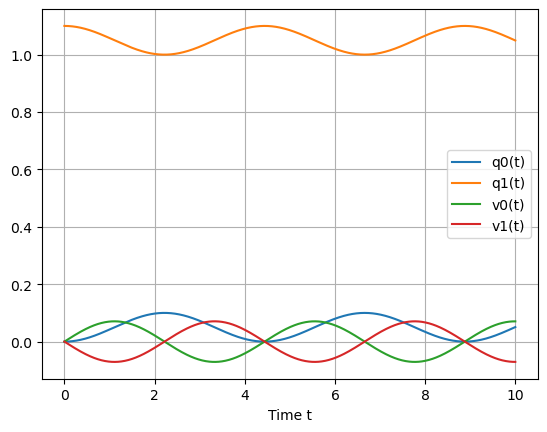

In [5]:
# Plot the results
plt.plot(sol.t, sol.y[0], label='q0(t)')
plt.plot(sol.t, sol.y[1], label='q1(t)')
plt.plot(sol.t, sol.y[2], label='v0(t)')
plt.plot(sol.t, sol.y[3], label='v1(t)')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

### Rigid spheres and elastic beam falling in a viscous fluid

In [6]:
l = 0.1
dl = l/2
q0 = jnp.array([0.,0.,l/2+0.,0.,l,0.]) # x1, y1, x2, y2, x3, y3
v0 = jnp.zeros(6)
z0 = jnp.concatenate([q0, v0])
print(z0)

[0.   0.   0.05 0.   0.1  0.   0.   0.   0.   0.   0.   0.  ]


In [49]:
# Material parameters
E = 1e9 # Young's modulus
r0 = 1e-3 # beam radius
EA = E*jnp.pi*r0**2 # stretching stiffenss
R1 = 5e-3 # first sphere radius
R2 = 25e-3 # second sphere's radius
R3 = R1 # radius third sphere
rho_m = 7000. # density of the metal (spheres)
rho_f = 1000. # density of the fluid
V = 4/3*jnp.pi*jnp.power(jnp.array([R1, R1, R2, R2, R3, R3]),3) # volumes of the spheres
m = rho_m * V # masses of the spheres
mu = 1000. # fluid viscosity

def P(q):
    p_vec = q.reshape(-1,2)
    edge_vectors = p_vec[1:,:] - p_vec[:-1,:]
    stretch = (1/dl)*jnp.linalg.norm(edge_vectors, axis=1)
    return 0.5*EA*jnp.sum((1.-stretch)**2*dl)

# Viscous damping coefficients
c = 6*jnp.pi*mu*jnp.array([R1, R1, R2, R2, R3, R3])

# Buoyancy forces
F = -V*jnp.array([0.,1.,0.,1.,0.,1.])*(rho_m-rho_f)*9.81*0

In [50]:
print(P(q0))
print(equations_of_motion(0.,z0,P, m,c,F))

0.0
[ 0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.]


In [51]:
# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = jnp.linspace(t_span[0], t_span[1], 1000)  # points at which to store the solution

# LINK TO scipy doc about solve_ivp and docs about RK45 and BDF
# Solve the system using RK45 (explicit method)
# jitted_equations_of_motion = jit(equations_of_motion, static_argnames=("gradP",))
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), t_eval=t_eval)
# Solve the system using BDF (implicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), method="BDF", t_eval=t_eval, jac=jacobian)

(12, 1000)


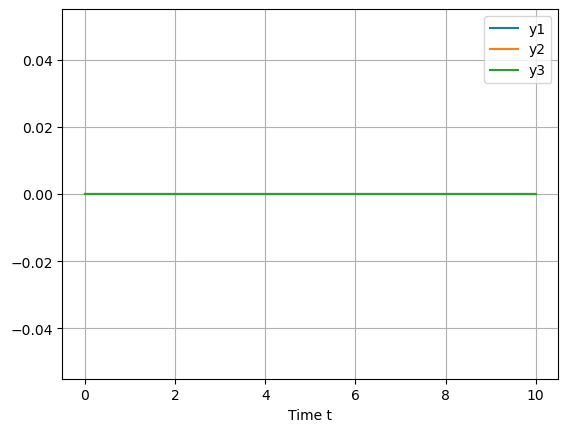

In [52]:
# Plot the results
print(sol.y.shape)
x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = sol.y
q = jnp.array([x1,y1,x2,y2,x3,y3])
plt.plot(sol.t, y1, label='y1')
plt.plot(sol.t, y2, label='y2')
plt.plot(sol.t, y3, label='y3')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

TODO:
1. plots of kinetic and potential energy (also without damping), comparison of time
   integration methods (RK, BDF, Velocity Verlet)
2. bending energy
3. generalization to N spheres
4. elastic beam bending